In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# Define path to a sample episode file
# Based on your workspace structure: data/beat_block_hammer/demo_3d_vision_easy/data/episode0.hdf5
data_path = "../data/beat_block_hammer/demo_3d_vision_easy/data/episode0.hdf5"

def print_hdf5_structure(name, obj):
    if isinstance(obj, h5py.Group):
        print(f"Group: {name}")
    elif isinstance(obj, h5py.Dataset):
        print(f"Dataset: {name}, Shape: {obj.shape}, Dtype: {obj.dtype}")

if os.path.exists(data_path):
    with h5py.File(data_path, "r") as f:
        print(f"Structure of {data_path}:")
        f.visititems(print_hdf5_structure)
        
        # Load data for visualization
        # Based on process_data.py logic
        left_gripper = f["/joint_action/left_gripper"][()]
        left_arm = f["/joint_action/left_arm"][()]
        right_gripper = f["/joint_action/right_gripper"][()]
        right_arm = f["/joint_action/right_arm"][()]
        vector = f["/joint_action/vector"][()]
        pointcloud = f["/pointcloud"][()]
        
        print("\nLoaded Data Shapes:")
        print(f"Left Gripper: {left_gripper.shape}")
        print(f"Left Arm: {left_arm.shape}")
        print(f"Right Gripper: {right_gripper.shape}")
        print(f"Right Arm: {right_arm.shape}")
        print(f"Vector (Joint State): {vector.shape}")
        print(f"Pointcloud: {pointcloud.shape}")
else:
    print(f"File not found: {data_path}")

Structure of ../data/beat_block_hammer/demo_3d_vision_easy/data/episode0.hdf5:
Group: endpose
Dataset: endpose/left_endpose, Shape: (120, 7), Dtype: float64
Dataset: endpose/left_gripper, Shape: (120,), Dtype: float64
Dataset: endpose/right_endpose, Shape: (120, 7), Dtype: float64
Dataset: endpose/right_gripper, Shape: (120,), Dtype: float64
Group: joint_action
Dataset: joint_action/left_arm, Shape: (120, 6), Dtype: float64
Dataset: joint_action/left_gripper, Shape: (120,), Dtype: float64
Dataset: joint_action/right_arm, Shape: (120, 6), Dtype: float64
Dataset: joint_action/right_gripper, Shape: (120,), Dtype: float64
Dataset: joint_action/vector, Shape: (120, 14), Dtype: float64
Group: observation
Group: observation/front_camera
Dataset: observation/front_camera/actor_segmentation, Shape: (120, 240, 320, 3), Dtype: uint8
Dataset: observation/front_camera/cam2world_gl, Shape: (120, 4, 4), Dtype: float32
Dataset: observation/front_camera/depth, Shape: (120, 240, 320), Dtype: float64
Dat

In [4]:
# Visualize Point Cloud for a specific frame using Plotly (Interactive)
import plotly.graph_objects as go

frame_idx = 0  # Change this to view different frames

if 'pointcloud' in locals():
    pc_frame = pointcloud[frame_idx]
    print(f"Visualizing frame {frame_idx}, Point Cloud Shape: {pc_frame.shape}")
    
    # Subsample for faster rendering if needed
    step = 1
    
    fig = go.Figure(data=[go.Scatter3d(
        x=pc_frame[::step, 0],
        y=pc_frame[::step, 1],
        z=pc_frame[::step, 2],
        mode='markers',
        marker=dict(
            size=2,
            color=pc_frame[::step, 2],                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8
        )
    )])

    fig.update_layout(
        title=f'Point Cloud at Frame {frame_idx}',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )
    fig.show()
else:
    print("Pointcloud data not loaded.")

Visualizing frame 0, Point Cloud Shape: (1024, 6)


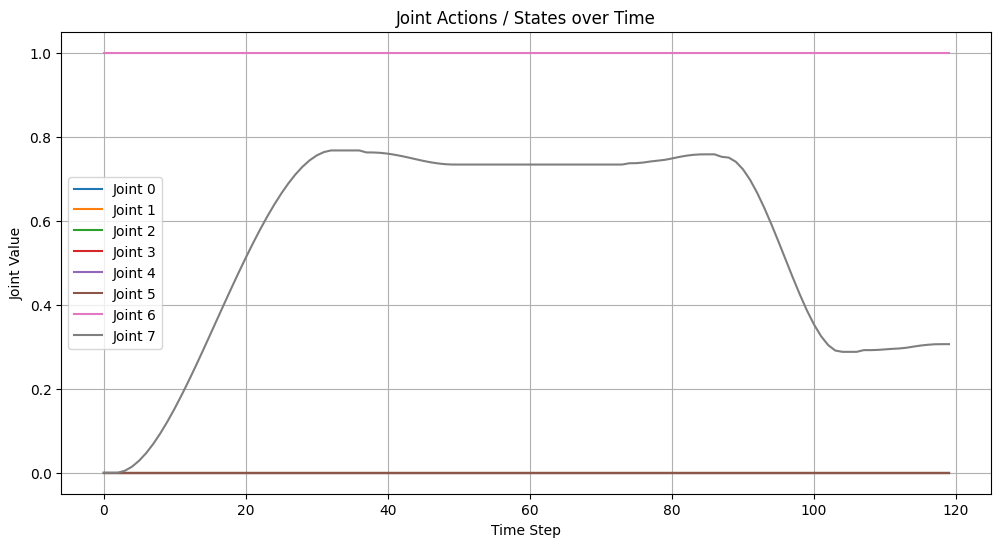

In [5]:
# Visualize Joint Actions over time
if 'vector' in locals():
    plt.figure(figsize=(12, 6))
    # Assuming vector contains joint states, plotting the first few dimensions
    for i in range(min(vector.shape[1], 8)): # Plot first 8 joints
        plt.plot(vector[:, i], label=f'Joint {i}')
    
    plt.xlabel('Time Step')
    plt.ylabel('Joint Value')
    plt.title('Joint Actions / States over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Vector data not loaded.")

Found 8 image datasets: ['observation/front_camera/actor_segmentation', 'observation/front_camera/mesh_segmentation', 'observation/head_camera/actor_segmentation', 'observation/head_camera/mesh_segmentation', 'observation/left_camera/actor_segmentation', 'observation/left_camera/mesh_segmentation', 'observation/right_camera/actor_segmentation', 'observation/right_camera/mesh_segmentation']


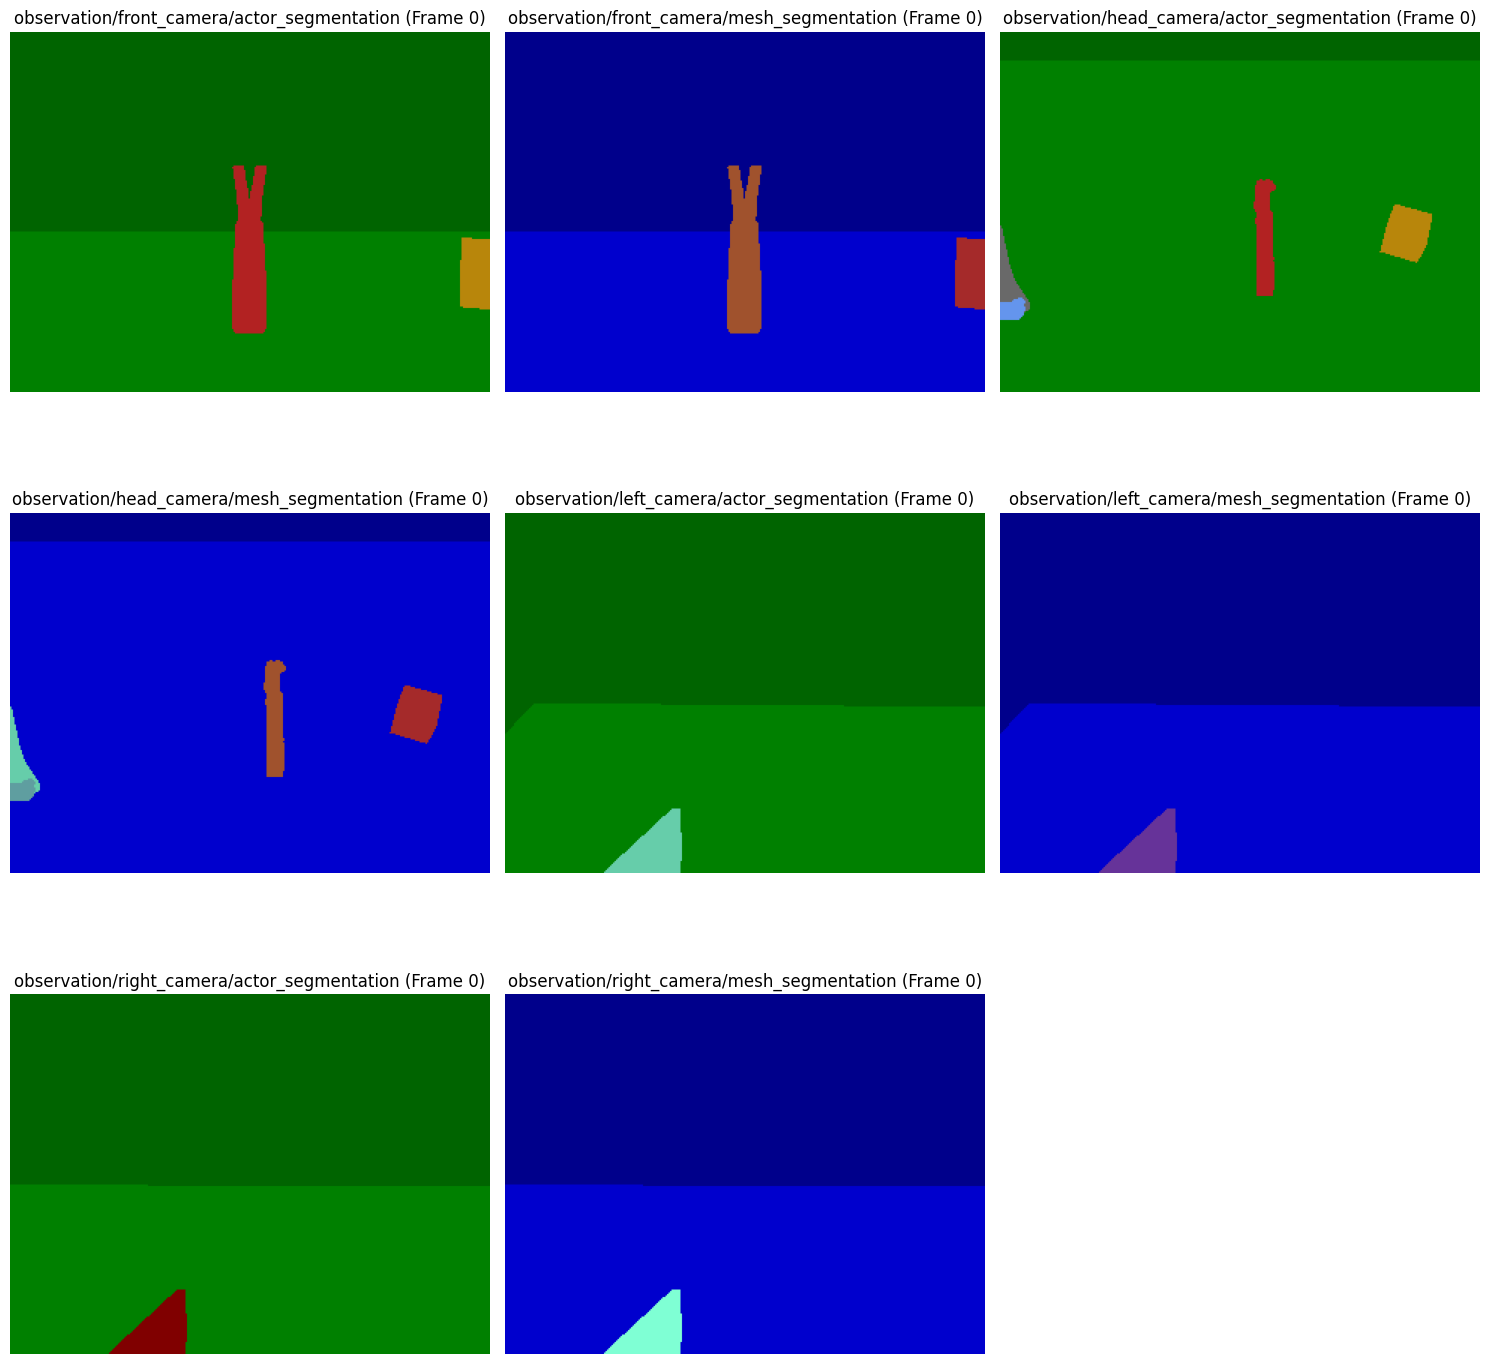

In [6]:
# Visualize all RGB images for the first frame
frame_idx = 0

if os.path.exists(data_path):
    with h5py.File(data_path, "r") as f:
        # Find all datasets that look like images (3 dimensions, usually uint8)
        image_keys = []
        def find_images(name, obj):
            if isinstance(obj, h5py.Dataset) and len(obj.shape) == 4 and obj.shape[-1] == 3: # (T, H, W, C)
                image_keys.append(name)
        
        f.visititems(find_images)
        
        if image_keys:
            print(f"Found {len(image_keys)} image datasets: {image_keys}")
            
            # Calculate grid size
            n_images = len(image_keys)
            cols = 3
            rows = (n_images + cols - 1) // cols
            
            plt.figure(figsize=(15, 5 * rows))
            
            for i, key in enumerate(image_keys):
                img_data = f[key][frame_idx]
                
                plt.subplot(rows, cols, i + 1)
                plt.imshow(img_data)
                plt.title(f"{key} (Frame {frame_idx})")
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()
        else:
            print("No RGB image datasets found (looking for 4D arrays with 3 channels).")
else:
    print(f"File not found: {data_path}")

Found 4 compressed image datasets: ['observation/front_camera/rgb', 'observation/head_camera/rgb', 'observation/left_camera/rgb', 'observation/right_camera/rgb']


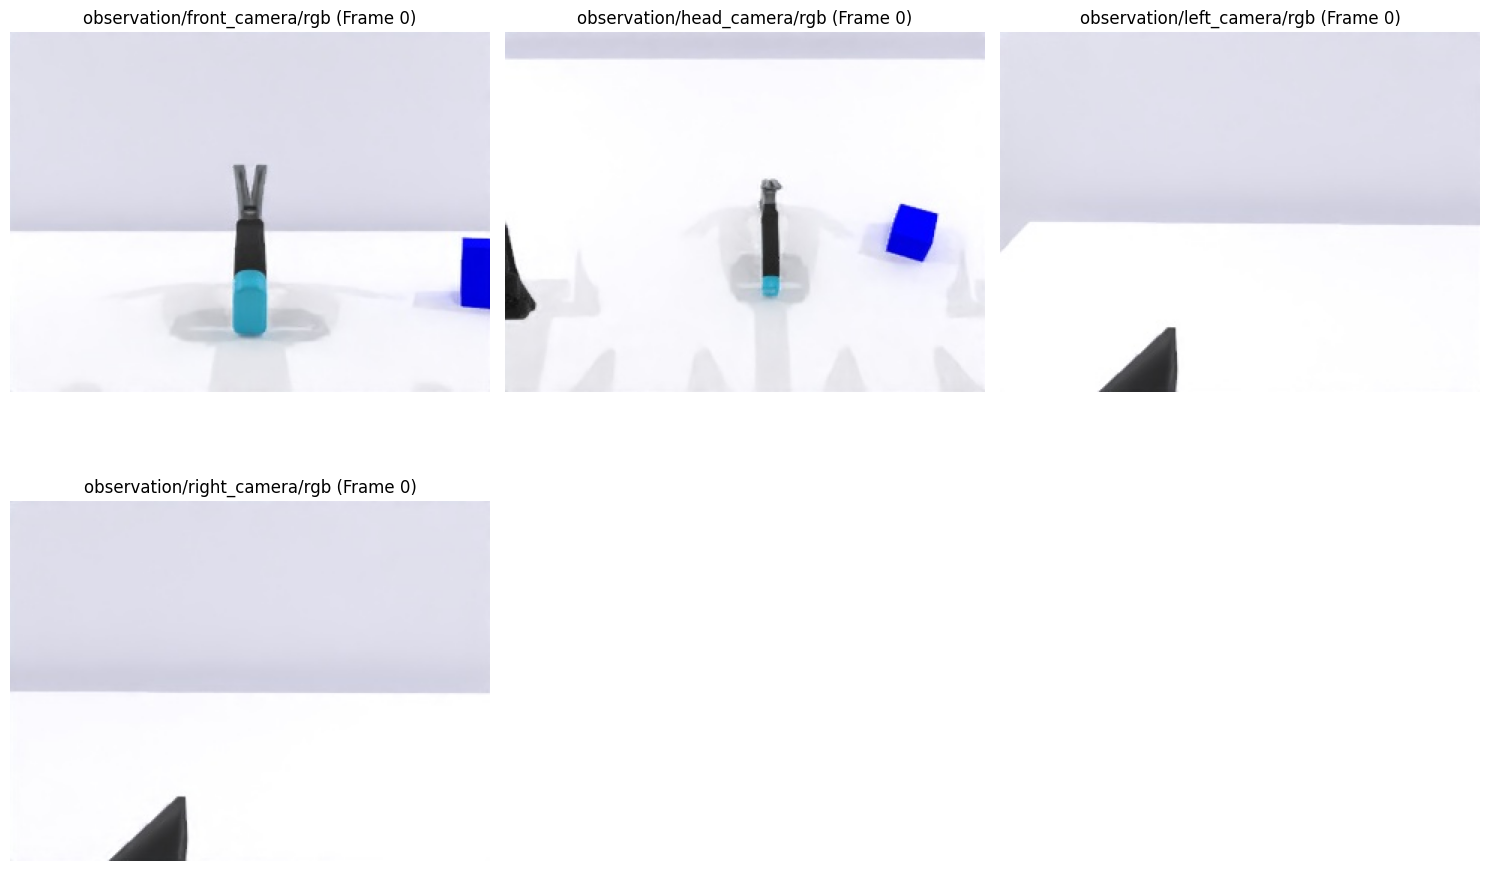

In [7]:
# Visualize compressed RGB images (stored as bytes)
import cv2
import io
from PIL import Image

frame_idx = 0

if os.path.exists(data_path):
    with h5py.File(data_path, "r") as f:
        # Find datasets that look like compressed images (1D array of strings/bytes)
        compressed_image_keys = []
        def find_compressed_images(name, obj):
            # Heuristic: 1D array, dtype is string/bytes (S or O), and name contains 'rgb'
            if isinstance(obj, h5py.Dataset) and len(obj.shape) == 1 and ('rgb' in name or 'image' in name):
                # Check if it's likely bytes (dtype 'S' or 'O')
                if obj.dtype.kind in ('S', 'O'):
                    compressed_image_keys.append(name)
        
        f.visititems(find_compressed_images)
        
        if compressed_image_keys:
            print(f"Found {len(compressed_image_keys)} compressed image datasets: {compressed_image_keys}")
            
            n_images = len(compressed_image_keys)
            cols = 3
            rows = (n_images + cols - 1) // cols
            
            plt.figure(figsize=(15, 5 * rows))
            
            for i, key in enumerate(compressed_image_keys):
                # Get the raw bytes for the specific frame
                img_bytes = f[key][frame_idx]
                
                try:
                    # Try decoding with cv2 (assuming it might be numpy array of bytes)
                    # Often these are stored as numpy void or string types that need to be cast to bytes
                    if isinstance(img_bytes, np.void):
                        img_bytes = img_bytes.tobytes()
                    
                    # Method 1: Try PIL
                    try:
                        image = Image.open(io.BytesIO(img_bytes))
                        img_array = np.array(image)
                    except:
                        # Method 2: Try cv2 decoding
                        nparr = np.frombuffer(img_bytes, np.uint8)
                        img_array = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
                        if img_array is not None:
                            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                    
                    if img_array is not None:
                        plt.subplot(rows, cols, i + 1)
                        plt.imshow(img_array)
                        plt.title(f"{key} (Frame {frame_idx})")
                        plt.axis('off')
                    else:
                        print(f"Failed to decode image for {key}")
                        
                except Exception as e:
                    print(f"Error processing {key}: {e}")
            
            plt.tight_layout()
            plt.show()
        else:
            print("No compressed RGB image datasets found.")
else:
    print(f"File not found: {data_path}")